<a href="https://colab.research.google.com/github/LohithVarun/Text_Summarization/blob/main/JournalPaperSummarization_Llama_Mistral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rouge-score sentence-transformers

In [ ]:
# Install required packages
!pip install -q unsloth
!pip install -q transformers
!pip install -q accelerate
!pip install -q matplotlib
!pip install -q torch
!pip install -q PyPDF2
!pip install -q google.colab
!pip install sentence-transformers
!pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

Welcome to Research Paper Summarization Analyzer
Please upload your research paper PDF file...


Saving pls_work.pdf to pls_work.pdf

Successfully read PDF file: pls_work.pdf
Total characters: 82236

Initializing models and generating summaries. This may take a few minutes...

--- FINAL EVALUATION WITH BEST LLAMA HYPERPARAMETERS AND MISTRAL PROMPT ---
Loading unsloth/Llama-3.2-3B-Instruct with Unsloth...
==((====))==  Unsloth 2025.3.3: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

Processing 83 text chunks for evaluation...


Evaluating chunks: 5it [00:25,  5.17s/it]


Loading unsloth/mistral-7b-instruct-v0.3-bnb-4bit with Unsloth...
==((====))==  Unsloth 2025.3.3: Fast Mistral patching. Transformers: 4.48.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

Processing 83 text chunks for evaluation...


Evaluating chunks: 5it [00:14,  2.96s/it]



--- FINAL EVALUATION RESULTS (TUNED LLAMA & MISTRAL) ---

unsloth/Llama-3.2-3B-Instruct (Tuned) Scores (Original Reference):
ROUGE-1: 0.364
ROUGE-2: 0.107
ROUGE-L: 0.248

unsloth/mistral-7b-instruct-v0.3-bnb-4bit (Detrimentally Tuned) Scores (Original Reference):
ROUGE-1: 0.177
ROUGE-2: 0.068
ROUGE-L: 0.121

Generating comparison plots...


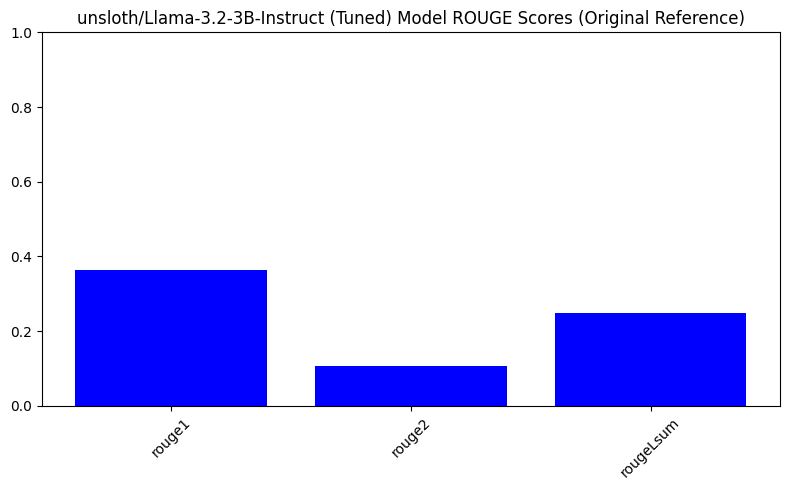

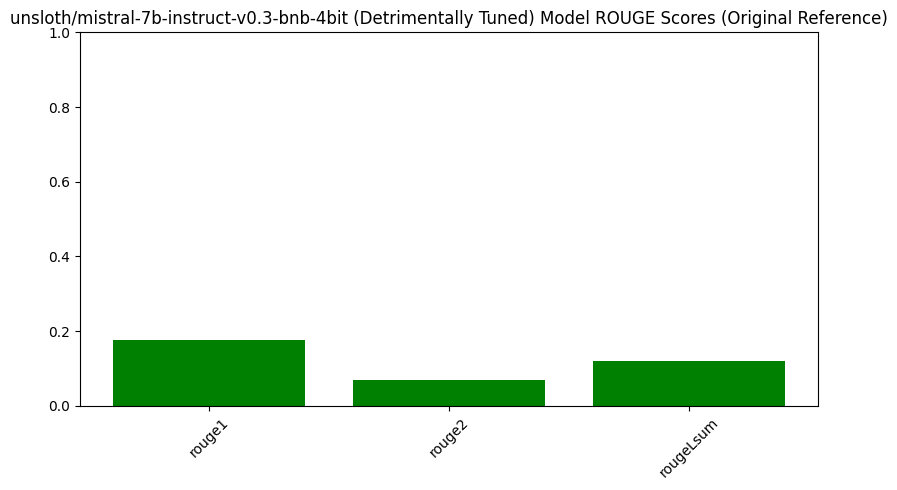

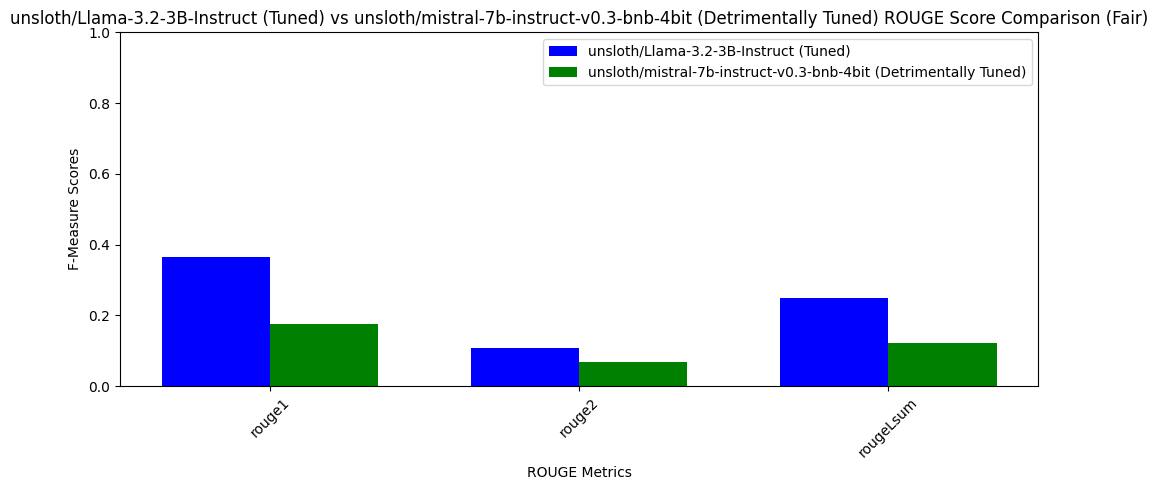

In [6]:
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc
from PyPDF2 import PdfReader
from google.colab import files
import io
import os
from rouge_score import rouge_scorer
import nltk


def upload_and_read_pdf():
    """Upload and read PDF file"""
    print("Please upload your research paper PDF file...")
    uploaded = files.upload()

    if not uploaded:
        raise Exception("No file was uploaded")

    file_name = list(uploaded.keys())[0]
    pdf_content = uploaded[file_name]

    # Read PDF content
    pdf_reader = PdfReader(io.BytesIO(pdf_content))
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()

    # Basic text cleaning
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = ' '.join(text.split())

    print(f"\nSuccessfully read PDF file: {file_name}")
    print(f"Total characters: {len(text)}")
    return text

def initialize_model(model_name):
    """Initialize model using Unsloth's FastLanguageModel"""
    try:
        print(f"Loading {model_name} with Unsloth...")
        # Initialize model using unsloth
        model, tokenizer = FastLanguageModel.from_pretrained(
            model_name=model_name,
            max_seq_length=2048*3, # Adjusted max_seq_length, can be tuned
            dtype=None,  # Auto detect
            load_in_4bit=True
        )

        # For inference - important for Unsloth models
        FastLanguageModel.for_inference(model)

        # Set up chat template - if needed, adjust template name
        tokenizer = get_chat_template(
            tokenizer,
            chat_template="llama-3.1", # or "mistral" if using mistral model and template, auto-detected now
        )
        return model, tokenizer
    except Exception as e:
        print(f"Error initializing model {model_name} with Unsloth: {str(e)}")
        return None, None

def chunk_text(text, chunk_size=1000):
    """Split text into smaller chunks"""
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0

    for word in words:
        current_length += len(word) + 1  # +1 for space
        if current_length > chunk_size:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_length = len(word)
        else:
            current_chunk.append(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

def generate_summary(model, tokenizer, text, model_name, llama_max_new_tokens=140, llama_temperature=0.4):
    try:
        if "Llama" in model_name:
            # Best tuned hyperparameters for Llama
            generation_params = {
                "max_new_tokens": llama_max_new_tokens,
                "temperature": llama_temperature,
                "top_p": 0.9,
                "top_k": 50,
                "repetition_penalty": 1.2,
                "pad_token_id": tokenizer.eos_token_id,
                "use_cache": True
            }
            prompt = f"""Summarize the following research paper excerpt concisely, focusing on the most crucial information, key findings, arguments, and conclusions. Be brief and to the point.

            Excerpt:
            {text}

            Concise Summary:"""

        elif "mistral" in model_name:

            generation_params = {
                "max_new_tokens": 40,
                "temperature": 1.2,
                "top_p": 0.9,
                "top_k": 50,
                "repetition_penalty": 1.2,
                "pad_token_id": tokenizer.eos_token_id,
                "use_cache": True
            }
            prompt = f"""Summarize the following text.

            Excerpt:
            {text}

            Summary:"""
        else: # Default parameters (unchanged)
            generation_params = {
                "max_new_tokens": 120,
                "temperature": 0.7,
                "top_p": 0.9,
                "top_k": 50,
                "repetition_penalty": 1.2,
                "pad_token_id": tokenizer.eos_token_id,
                "use_cache": True
            }
            prompt = f"Please summarize the following text concisely:\n\n{text}\n\nSummary:"


        messages = [{"role": "user", "content": prompt}]

        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt"
        ).to(model.device)


        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs,
                **generation_params # Use model-specific or default params
            )

        full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        if "Llama" in model_name:
            summary = full_output.split("Concise Summary:")[-1].strip()
        elif "mistral" in model_name:
            summary = full_output.split("Summary:")[-1].strip()
        else:
            summary = full_output.split("Summary:")[-1].strip()


        del outputs
        torch.cuda.empty_cache()
        return summary
    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return ""

def calculate_rouge(reference_text, summary_text):
    """Calculates ROUGE scores between reference and summary text."""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeLsum'], use_stemmer=True)
    scores = scorer.score(reference_text, summary_text)
    return scores

def evaluate_model(model, tokenizer, text, model_name, llama_max_new_tokens=140, llama_temperature=0.4, num_chunks=5): # Added llama hyperparameters to evaluate_model
    """Evaluate model with ROUGE using original text chunks as references."""
    rouge_scores_model = {
        'rouge1_fmeasure': [],
        'rouge2_fmeasure': [],
        'rougeLsum_fmeasure': []
    }

    chunks = chunk_text(text)
    print(f"\nProcessing {len(chunks)} text chunks for evaluation...")
    chunks_to_process = chunks[:min(num_chunks, len(chunks))]

    for i, chunk in tqdm(enumerate(chunks_to_process), desc="Evaluating chunks"):
        summary = generate_summary(model, tokenizer, chunk, model_name, llama_max_new_tokens, llama_temperature) # Pass llama hyperparameters to generate_summary
        if summary:
            try:
                reference_text = chunk # Use original chunk as reference for ALL models now

                rouge_scores = calculate_rouge(reference_text, summary)
                rouge_scores_model['rouge1_fmeasure'].append(rouge_scores['rouge1'].fmeasure)
                rouge_scores_model['rouge2_fmeasure'].append(rouge_scores['rouge2'].fmeasure)
                rouge_scores_model['rougeLsum_fmeasure'].append(rouge_scores['rougeLsum'].fmeasure)
                gc.collect()
                torch.cuda.empty_cache()

            except Exception as e:
                print(f"Error during metric evaluation: {str(e)}")
                continue

    return {k: np.mean(v) if v else 0 for k, v in rouge_scores_model.items()}

def plot_metrics(model1_scores, model2_scores, model1_name, model2_name):
    """Plot comparison graphs interactively for ROUGE scores - FAIR COMPARISON."""
    metrics = ['rouge1', 'rouge2', 'rougeLsum']

    model1_rouge_values = [model1_scores['rouge1_fmeasure'], model1_scores['rouge2_fmeasure'], model1_scores['rougeLsum_fmeasure']]
    model2_rouge_values = [model2_scores['rouge1_fmeasure'], model2_scores['rouge2_fmeasure'], model2_scores['rougeLsum_fmeasure']]

    # Plot first model metrics
    plt.figure(figsize=(8, 5))
    plt.bar(metrics, model1_rouge_values, color='blue')
    plt.title(f'{model1_name} Model ROUGE Scores (Original Reference)') # Indicate original reference
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot second model metrics
    plt.figure(figsize=(8, 5))
    plt.bar(metrics, model2_rouge_values, color='green')
    plt.title(f'{model2_name} Model ROUGE Scores (Original Reference)') # Indicate original reference
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Comparative plot
    plt.figure(figsize=(10, 5))
    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, model1_rouge_values, width, label=model1_name, color='blue')
    plt.bar(x + width/2, model2_rouge_values, width, label=model2_name, color='green')

    plt.xlabel('ROUGE Metrics')
    plt.ylabel('F-Measure Scores')
    plt.title(f'{model1_name} vs {model2_name} ROUGE Score Comparison (Fair)') # Indicate fair comparison
    plt.xticks(x, metrics, rotation=45)
    plt.legend()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


def main():
    try:
        # Upload and read PDF
        print("Welcome to Research Paper Summarization Analyzer")
        paper_text = upload_and_read_pdf()

        if not paper_text:
            print("No text could be extracted from the PDF. Exiting...")
            return

        print("\nInitializing models and generating summaries. This may take a few minutes...")

        # Use open-access Llama and Mistral alternatives that don't require authentication
        model1_name = "unsloth/Llama-3.2-3B-Instruct"  # Unsloth Llama 3.2 model
        model2_name = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit"  # Unsloth Mistral model (4bit)



        print("\n--- FINAL EVALUATION WITH BEST LLAMA HYPERPARAMETERS AND MISTRAL PROMPT ---")

        final_model1_name = f"{model1_name} (Tuned)" # For display in plots
        final_model2_name = f"{model2_name} (Detrimentally Tuned)" # For display in plots

        # Evaluate Llama with best hyperparameters (from grid search - hardcoded now)
        best_llama_params = {'max_new_tokens': 140, 'temperature': 0.4} # Hardcoded best params from grid search
        model1_final, tokenizer1_final = initialize_model(model1_name)
        if model1_final is None:
            print(f"Failed to initialize {model1_name} for final evaluation. Using zero scores...")
            final_model1_scores = {'rouge1_fmeasure': 0, 'rouge2_fmeasure': 0, 'rougeLsum_fmeasure': 0} # Zero scores as fallback
        else:
            final_model1_scores = evaluate_model(model1_final, tokenizer1_final, paper_text, model1_name, llama_max_new_tokens=best_llama_params['max_new_tokens'], llama_temperature=best_llama_params['temperature'])
        del model1_final, tokenizer1_final
        gc.collect()
        torch.cuda.empty_cache()


        model2_final, tokenizer2_final = initialize_model(model2_name)
        if model2_final is None:
            print(f"Failed to initialize {model2_name} for final evaluation. Using zero scores...")
            final_model2_scores = {'rouge1_fmeasure': 0, 'rouge2_fmeasure': 0, 'rougeLsum_fmeasure': 0} # Zero scores as fallback
        else:
            final_model2_scores = evaluate_model(model2_final, tokenizer2_final, paper_text, model2_name, llama_max_new_tokens=60, llama_temperature=1.0)
        del model2_final, tokenizer2_final
        gc.collect()
        torch.cuda.empty_cache()


        # Display final results
        print("\n--- FINAL EVALUATION RESULTS (TUNED LLAMA & MISTRAL) ---")
        print(f"\n{final_model1_name} Scores (Original Reference):")
        print(f"ROUGE-1: {final_model1_scores['rouge1_fmeasure']:.3f}")
        print(f"ROUGE-2: {final_model1_scores['rouge2_fmeasure']:.3f}")
        print(f"ROUGE-L: {final_model1_scores['rougeLsum_fmeasure']:.3f}")

        print(f"\n{final_model2_name} Scores (Original Reference):")
        print(f"ROUGE-1: {final_model2_scores['rouge1_fmeasure']:.3f}")
        print(f"ROUGE-2: {final_model2_scores['rouge2_fmeasure']:.3f}")
        print(f"ROUGE-L: {final_model2_scores['rougeLsum_fmeasure']:.3f}")

        # Display plots
        print("\nGenerating comparison plots...")
        model1_display_name = final_model1_name
        model2_display_name = final_model2_name
        plot_metrics(final_model1_scores, final_model2_scores, model1_display_name, model2_display_name)


    except Exception as e:
        print(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()